<a href="https://colab.research.google.com/github/AtharvMali18/DETR/blob/master/Multihead_attention_10_epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Oct  7 04:59:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [5]:
!pip install -i https://test.pypi.org/simple/ supervision==0.3.0
!pip install -q transformers
!pip install -q pytorch-lightning
!pip install -q roboflow
!pip install -q timm

Looking in indexes: https://test.pypi.org/simple/
  Using cached https://test-files.pythonhosted.org/packages/9c/29/e30c575a94cb121417cd7725aecb6bbf78d14d923f42e0bce7cf7de9b3eb/supervision-0.3.0-py3-none-any.whl (21 kB)
  Attempting uninstall: supervision
    Found existing installation: supervision 0.15.0
    Uninstalling supervision-0.15.0:
      Successfully uninstalled supervision-0.15.0


In [6]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import roboflow
import supervision
import transformers
import pytorch_lightning

print(
    "roboflow:", roboflow.__version__,
    "; supervision:", supervision.__version__,
    "; transformers:", transformers.__version__,
    "; pytorch_lightning:", pytorch_lightning.__version__
)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
roboflow: 1.1.7 ; supervision: 0.3.0 ; transformers: 4.34.0 ; pytorch_lightning: 2.0.9.post0


In [7]:
%cd {HOME}
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

/content
--2023-10-07 05:00:27--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2023-10-07 05:00:27 (124 MB/s) - ‘dog.jpeg’ saved [106055/106055]



In [8]:

import os

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, IMAGE_NAME)

In [9]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor


# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'facebook/detr-resnet-50'
CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.8

image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
model = DetrForObjectDetection.from_pretrained(CHECKPOINT)
model.to(DEVICE)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

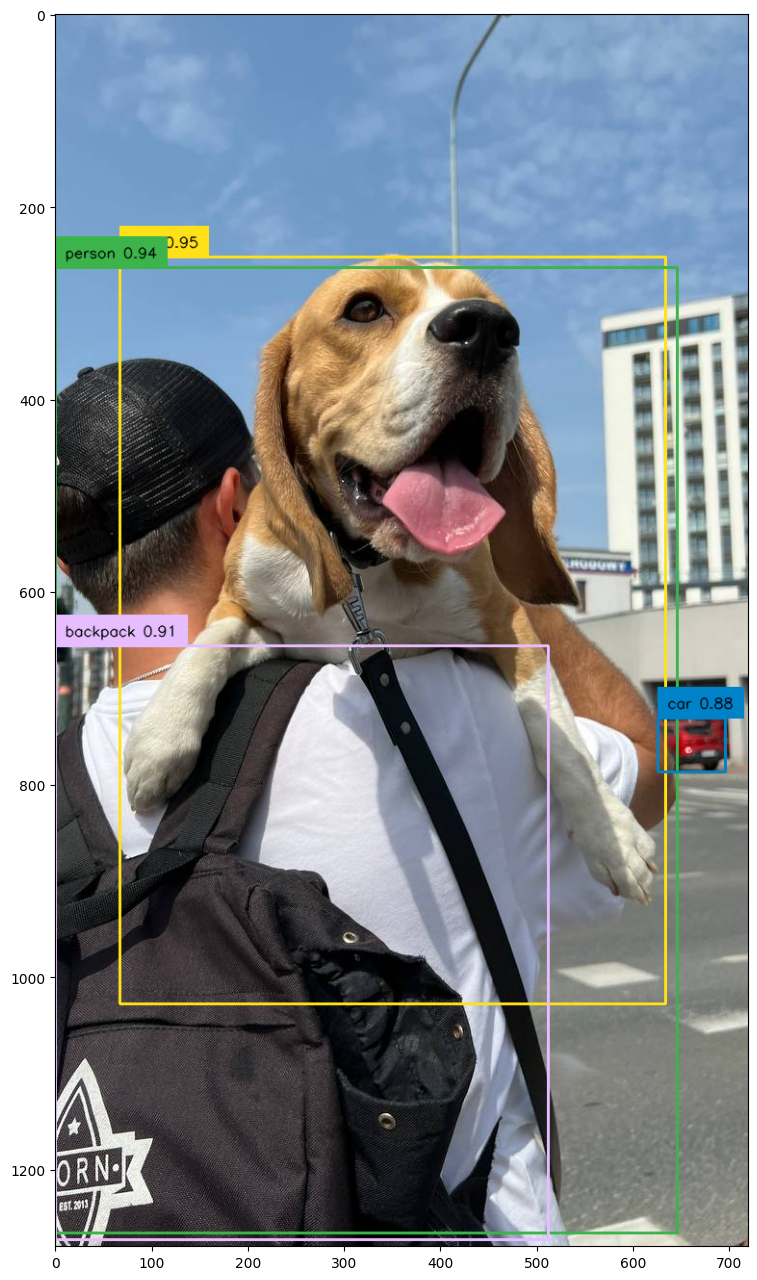

In [10]:
import cv2
import torch
import supervision as sv


with torch.no_grad():

    # load image and predict
    image = cv2.imread(IMAGE_PATH)
    inputs = image_processor(images=image, return_tensors='pt').to(DEVICE)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(DEVICE)
    results = image_processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONFIDENCE_TRESHOLD,
        target_sizes=target_sizes
    )[0]

# annotate
detections = sv.Detections.from_transformers(transformers_results=results).with_nms(threshold=IOU_TRESHOLD)

labels = [
    f"{model.config.id2label[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(frame, (16, 16))

In [11]:
from getpass import getpass
ROBOFLOW_API_KEY = getpass('Enter ROBOFLOW_API_KEY secret value: ')


Enter ROBOFLOW_API_KEY secret value: ··········


In [12]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="xcQbYC1hEy9cGxUM8W2Y")
project = rf.workspace("vishwakarma-institute-of-technology-yqqb5").project("edi-ty")
dataset = project.version(1).download("coco")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to EDI-TY-1 in coco:: 100%|██████████| 459/459 [00:00<00:00, 2807.45it/s]


In [13]:

dataset.location


'/content/EDI-TY-1'

In [14]:
import os
import torchvision


# settings
ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(dataset.location, "train")
VAL_DIRECTORY = os.path.join(dataset.location, "valid")
TEST_DIRECTORY = os.path.join(dataset.location, "test")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY,
    image_processor=image_processor,
    train=True)
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY,
    image_processor=image_processor,
    train=False)
TEST_DATASET = CocoDetection(
    image_directory_path=TEST_DIRECTORY,
    image_processor=image_processor,
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 316
Number of validation examples: 90
Number of test examples: 45


Image #29


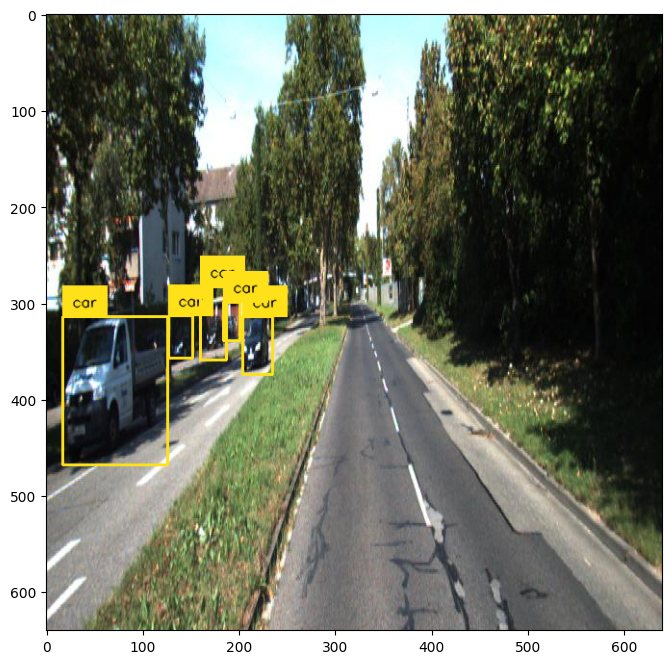

In [15]:
import random
import cv2
import numpy as np


# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}"
    for _, _, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline
sv.show_frame_in_notebook(image, (8, 8))

In [16]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

In [17]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch
import torch.nn as nn

class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay, num_attention_heads):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path=CHECKPOINT,
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay
        self.num_attention_heads = num_attention_heads

        # Add a self-attention module
        self.self_attention = nn.MultiheadAttention(embed_dim=256, num_heads=self.num_attention_heads)

    def forward(self, pixel_values, pixel_mask):
        # Pass input through the self-attention module
        attention_output, _ = self.self_attention(pixel_values, pixel_values, pixel_values)

        # Pass the attention output through the DETR model
        return self.model(pixel_values=attention_output, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here:
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER


In [18]:
# Define hyperparameters
LEARNING_RATE = 1e-4
LEARNING_RATE_BACKBONE = 1e-5
WEIGHT_DECAY = 1e-4
NUM_ATTENTION_HEADS = 4  # Adjust as needed

# Create an instance of the Detr model
model = Detr(lr=LEARNING_RATE, lr_backbone=LEARNING_RATE_BACKBONE, weight_decay=WEIGHT_DECAY, num_attention_heads=NUM_ATTENTION_HEADS)


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [19]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # Your collate_fn implementation here
    pass

# Load your training and validation dataloaders
TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)


In [20]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from transformers import DetrForObjectDetection

# Define your custom encoder block
class CustomEncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_heads=8, hidden_dim=2048, num_layers=1):
        super(CustomEncoderBlock, self).__init__()
        # Implement your encoder block here
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.LayerNorm(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.LayerNorm(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.norm1(out)
        out = torch.relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = torch.relu(out)
        return out

# Define your custom decoder block
class CustomDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_heads=8, hidden_dim=2048, num_layers=1):
        super(CustomDecoderBlock, self).__init__()
        # Implement your decoder block here
        self.self_attention = nn.MultiheadAttention(embed_dim=out_channels, num_heads=num_heads)
        self.norm1 = nn.LayerNorm(out_channels)
        self.cross_attention = nn.MultiheadAttention(embed_dim=out_channels, num_heads=num_heads)
        self.norm2 = nn.LayerNorm(out_channels)
        self.ffn = nn.Sequential(
            nn.Linear(out_channels, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_channels)
        )

    def forward(self, x, encoder_output):
        self_attn_output, _ = self.self_attention(x, x, x)
        x = x + self_attn_output
        x = self.norm1(x)

        cross_attn_output, _ = self.cross_attention(x, encoder_output, encoder_output)
        x = x + cross_attn_output
        x = self.norm2(x)

        ffn_output = self.ffn(x)
        x = x + ffn_output

        return x

# Create a custom DETR model
class CustomDetrForObjectDetection(DetrForObjectDetection):
    def __init__(self, config, custom_encoder, custom_decoder):
        super().__init__(config)
        self.encoder = custom_encoder
        self.decoder = custom_decoder

# Define your Lightning module using the custom DETR model
class CustomDetr(pl.LightningModule):
    def __init__(self, lr, lr_backbone, weight_decay, custom_encoder, custom_decoder):
        super().__init__()
        self.model = CustomDetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path="facebook/detr-resnet-50",  # Example model identifier
            custom_encoder=custom_encoder,
            custom_decoder=custom_decoder,
        )
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("training_loss", loss)
        for k, v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]
            },
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER  # Replace with your training data loader

    def val_dataloader(self):
        return VAL_DATALOADER  # Replace with your validation data loader

# Create an instance of your custom encoder and decoder
custom_encoder = CustomEncoderBlock(in_channels=256, out_channels=256)  # Adjust input and output channels as needed
custom_decoder = CustomDecoderBlock(in_channels=256, out_channels=256)  # Adjust input and output channels as needed

# Create an instance of your custom DETR model
custom_detr_model = CustomDetr(lr=0.001, lr_backbone=0.0001, weight_decay=0.0001,
                               custom_encoder=custom_encoder, custom_decoder=custom_decoder)



#--------------------------------------------------------------------------------------------------#
# Define your training and validation data loaders (TRAIN_DATALOADER and VAL_DATALOADER)
# and then train your custom DETR model as before.

# To train your model, you should define TRAIN_DATALOADER and VAL_DATALOADER with your dataset and data loaders.
# Replace them with your actual data loaders for training and validation.

from torch.utils.data import DataLoader

def collate_fn(batch):
    # DETR authors employ various image sizes during training, making it not possible
    # to directly batch together images. Hence they pad the images to the biggest
    # resolution in a given batch, and create a corresponding binary pixel_mask
    # which indicates which pixels are real/which are padding
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)


custom_encoder = CustomEncoderBlock(in_channels=256, out_channels=256)  # Adjust input and output channels as needed
custom_decoder = CustomDecoderBlock(in_channels=256, out_channels=256)  # Adjust input and output channels as needed

# Create an instance of your custom DETR model
custom_detr_model = CustomDetr(lr=0.001, lr_backbone=0.0001, weight_decay=0.0001,
                               custom_encoder=custom_encoder, custom_decoder=custom_decoder)

# Initialize a PyTorch Lightning Trainer
# Initialize a PyTorch Lightning Trainer
trainer = pl.Trainer(
    max_epochs=10,  # Set the number of training epochs
    num_sanity_val_steps=0,  # Set to 0 to skip initial validation check
)

# Create an instance of your custom encoder and decoder
custom_encoder = CustomEncoderBlock(in_channels=256, out_channels=256)  # Adjust input and output channels as needed
custom_decoder = CustomDecoderBlock(in_channels=256, out_channels=256)  # Adjust input and output channels as needed

# Create an instance of your custom DETR model
custom_detr_model = CustomDetr(lr=0.001, lr_backbone=0.0001, weight_decay=0.0001,
                               custom_encoder=custom_encoder, custom_decoder=custom_decoder)

# Train the custom DETR model
trainer.fit(custom_detr_model)

Some weights of CustomDetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized: ['decoder.norm1.weight', 'encoder.norm1.bias', 'decoder.ffn.2.bias', 'decoder.self_attention.in_proj_bias', 'decoder.norm1.bias', 'decoder.cross_attention.out_proj.weight', 'decoder.cross_attention.out_proj.bias', 'encoder.conv2.weight', 'decoder.norm2.bias', 'encoder.norm2.bias', 'encoder.conv2.bias', 'decoder.norm2.weight', 'encoder.norm2.weight', 'decoder.ffn.2.weight', 'decoder.self_attention.out_proj.bias', 'decoder.self_attention.out_proj.weight', 'decoder.self_attention.in_proj_weight', 'decoder.cross_attention.in_proj_weight', 'encoder.norm1.weight', 'encoder.conv1.bias', 'encoder.conv1.weight', 'decoder.cross_attention.in_proj_bias', 'decoder.ffn.0.bias', 'decoder.ffn.0.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of CustomDetrForObjectDetection w

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [22]:
# Save the custom model to the 'custom_detr_model' directory
CUSTOM_MODEL_PATH = 'custom_detr_model'
model.model.save_pretrained(CUSTOM_MODEL_PATH)

# Load the custom model from the 'custom_detr_model' directory
custom_model = DetrForObjectDetection.from_pretrained(CUSTOM_MODEL_PATH)
custom_model.to(DEVICE)


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [23]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image

# Define the path to your custom model
CUSTOM_MODEL_PATH = 'custom_detr_model'

# Set the device (CPU or GPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model and move it to the specified device
custom_model = DetrForObjectDetection.from_pretrained(CUSTOM_MODEL_PATH)
custom_model.to(DEVICE)
custom_model.eval()

# Load a random image (replace with your own image loading code)
random_image = Image.open('/content/res13.jpg')

# Apply preprocessing to the image
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
inputs = processor(images=random_image, return_tensors="pt")

# Move the inputs to the specified device
inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

# Perform inference
with torch.no_grad():
    outputs = custom_model(**inputs)

# Post-process the outputs to obtain bounding boxes and labels
target_sizes = torch.tensor([random_image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.2)[0]

# Interpret the results
# Example: Print the labels, scores, and bounding boxes
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    print(f"Label: {label.item()}, Score: {score.item():.2f}")
    print(f"Bounding Box: {box.tolist()}")


Label: 5, Score: 0.23
Bounding Box: [0.07917284965515137, 297.16009521484375, 36.65331268310547, 427.089599609375]
Label: 3, Score: 0.30
Bounding Box: [208.86940002441406, 94.1142578125, 227.75906372070312, 166.33892822265625]
Label: 4, Score: 0.24
Bounding Box: [0.10219812393188477, 225.55099487304688, 46.65782928466797, 636.8425903320312]
Label: 3, Score: 0.25
Bounding Box: [206.5438690185547, 71.17174530029297, 223.6074981689453, 109.13282775878906]
Label: 3, Score: 0.35
Bounding Box: [183.8622283935547, 66.569091796875, 226.37881469726562, 185.1270294189453]
Label: 4, Score: 0.23
Bounding Box: [182.11488342285156, 318.90771484375, 303.5617980957031, 438.256591796875]
Label: 4, Score: 0.20
Bounding Box: [191.01193237304688, 212.33419799804688, 210.84536743164062, 244.19302368164062]
Label: 5, Score: 0.25
Bounding Box: [140.9546661376953, 281.2894287109375, 164.8094940185547, 324.4936828613281]
Label: 3, Score: 0.28
Bounding Box: [165.8890380859375, 80.82774353027344, 182.20938110351

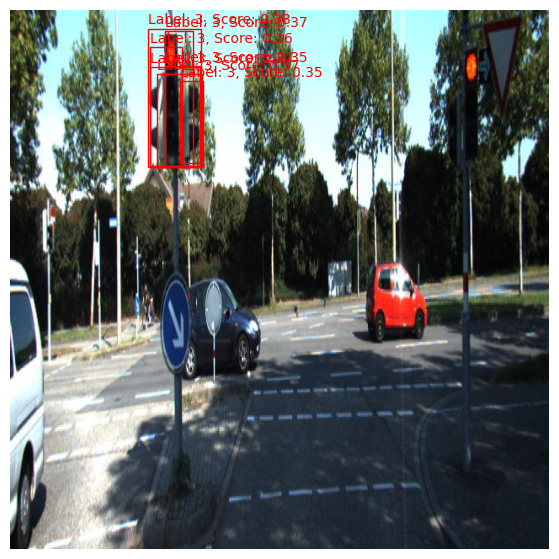

In [25]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define the path to your custom model
CUSTOM_MODEL_PATH = 'custom_detr_model'

# Set the device (CPU or GPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model and move it to the specified device
custom_model = DetrForObjectDetection.from_pretrained(CUSTOM_MODEL_PATH)
custom_model.to(DEVICE)
custom_model.eval()

# Load a random image (replace with your own image loading code)
random_image = Image.open('/content/res13.jpg')

# Apply preprocessing to the image
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
inputs = processor(images=random_image, return_tensors="pt")

# Move the inputs to the specified device
inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

# Perform inference
with torch.no_grad():
    outputs = custom_model(**inputs)

# Post-process the outputs to obtain bounding boxes and labels
target_sizes = torch.tensor([random_image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.35)[0]

# Display the image with bounding boxes
image_with_boxes = random_image.copy()
plt.figure(figsize=(10, 7))
ax = plt.gca()

# Draw bounding boxes
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    # Convert box coordinates to (x, y, width, height)
    x, y, w, h = box.tolist()
    rect = patches.Rectangle((x, y), w - x, h - y, linewidth=1, edgecolor="r", facecolor="none")
    ax.add_patch(rect)
    plt.text(x, y - 5, f"Label: {label.item()}, Score: {score.item():.2f}", color="r")

# Display the image
plt.imshow(image_with_boxes)
plt.axis("off")
plt.show()
